
# WWLayerIterator

This Notebook explains how to use the internal WeightWatcher Layer Iterators

Includes the WWStackerLayerIterator

- Stacks all weight matrices into a single, large, rectangular matrix

- Probably should normalize each layer in some consistent way *(not done yet)








In [1]:
# Suppress the powerlaw package warnings
# "powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide"
# "powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide"
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext watermark
%watermark

2021-09-05T13:08:54-07:00

CPython 3.8.5
IPython 7.18.1

compiler   : Clang 10.0.0 
system     : Darwin
release    : 17.7.0
machine    : x86_64
processor  : i386
CPU cores  : 12
interpreter: 64bit


### Import WeightWatcher

set custom Logging at WARN Level

In [3]:
import logging

import weightwatcher as ww
import torchvision.models as models

logger = logging.getLogger(ww.__name__)
logger.setLevel(logging.WARNING)

ww.__version__

'0.5.2'

###  How to create a WWLayerIterator

In [4]:
model = models.vgg11(pretrained=True)
watcher = ww.WeightWatcher(model=model)
ww_layer_iterator = watcher.make_layer_iterator(model=model)

### The Iterator lets you loop over WWLayer instances

- The WWLayer instance (object) is a wrapper to the underlying framework layers

- The intent is to only access the WWLayer instance and not the underlying framework methods

- This lets weightwatcher apply different functions / transformations on each layer individually



In [5]:
for ww_layer in ww_layer_iterator:
    print(ww_layer)

WWLayer 2  None PYTORCH CONV2D  skipped False
WWLayer 5  None PYTORCH CONV2D  skipped False
WWLayer 8  None PYTORCH CONV2D  skipped False
WWLayer 10  None PYTORCH CONV2D  skipped False
WWLayer 13  None PYTORCH CONV2D  skipped False
WWLayer 15  None PYTORCH CONV2D  skipped False
WWLayer 18  None PYTORCH CONV2D  skipped False
WWLayer 20  None PYTORCH CONV2D  skipped False
WWLayer 25  None PYTORCH DENSE  skipped False
WWLayer 28  None PYTORCH DENSE  skipped False
WWLayer 31  None PYTORCH DENSE  skipped False


### The WWLayerIterator constructor method takes

- layers=[LAYER_ID, ...] to specify filters, as in the watcher.analyze(..,) and watcher.describe(...) methods

- other parameters, like ww2x and channels, are specified in the parameters dict



In [6]:
logger = logging.getLogger('weightwatcher') 
logger.setLevel(logging.WARNING)


layers = [60]
DEFAULT_PARAMS = {'glorot_fix': False, 'normalize':False, 'conv2d_norm':True, 'randomize': True, 'savefig':False, 
                  'rescale':True , 'deltaEs':False, 'intra':False, 'channels':None, 'conv2d_fft':False, 
                  'ww2x':False}

params = DEFAULT_PARAMS
ww_layer_iterator = watcher.make_layer_iterator(model=model, layers=layers, params=params)



#### Now only 1 layer is processed

In [7]:
for ww_layer in ww_layer_iterator:
    print(ww_layer)

### WWLayer  Instances

When a WWLayer instance is created, the weight matrices for the layer are extracted from the underlying framework tensor (i.e. layer.weights and layer.biases) and placed into WMats

- WMats = [W,W,W,...] contains 1 or more W matrices, of the same shape NxM, N > M
- evals: the *combined* evals for each layer
- rf = 1 or (k)x(k)  the size of the 'receptive field'



- layer_type =  an internal enum:    known layer types so far include:

<pre>
LAYER_TYPE.DENSE | LAYER_TYPE.CONV1D | LAYER_TYPE.CONV2D | LAYER_TYPE.FLATTENED |  LAYER_TYPE.EMBEDDING | LAYER_TYPE.NORM
</pre>

- channel_str:  string for channel type :  "FIRST" | "LAST" | "UNKNOWN"



### WeightWatcher Apply Methods

#### The various apply_xxx() methods use basic metaprogramming to set additional instance variables


- apply_filters()
- apply_normalize_Wmats()
- apply_esd()
- apply_random_esd()
- apply_plot_esd()
- apply_fit_powerlaw()
- apply_norm_metrics()
- apply_plot_deltaEs()
- apply_mp_fit()
- apply_svdsmoothing()


i.e the apply_esd() method runs SVD on all the WMats, then combines them into a single ESD

<code>
#
    def apply_esd(self, ww_layer, params=AULT_PARAMS):
            """run full SVD on layer weight matrices, compute ESD on combined eigenvalues, combine all..."""
#
...
#
    ww_layer.evals = evals
    ww_layer.add_column("has_esd", True)
    ww_layer.add_column("num_evals", len(evals))
    ww_layer.add_column("sv_max", sv_max)
    ww_layer.add_column("rank_loss", rank_loss)
    ww_layer.add_column("lambda_max", np.max(evals))    
#      
    return ww_layer
</code>       
        


### There are different Iterators for different ways of walking the Model Layers

In [8]:
type(ww_layer_iterator)

weightwatcher.weightwatcher.WWLayerIterator

In [9]:
from weightwatcher.weightwatcher import WWLayerIterator

In [10]:
from weightwatcher.constants import LAYER_TYPE

In [11]:

class WWStackedLayerIterator(WWLayerIterator):
    """Iterator variant that sticaks all weight matrics into a single WWLayer"""
    from copy import deepcopy

    def ww_stacked_iter_(self):
        from copy import deepcopy
        
        # find the maximum dimensions so we can pad the matrices
        ww_stacked_layer = None
        Wmats = []
        for ww_layer in self.ww_layer_iter_():
            
            # Here, Ijust lazizy copy an older layer
            # really, we should creat the WWLayer using the init() constructor
            if ww_stacked_layer is None:
                ww_stacked_layer =  deepcopy(ww_layer)
                ww_stacked_layer.the_type =  LAYER_TYPE.COMBINED
                ww_stacked_layer.layer_id = 0  
                ww_stacked_layer.name = "Example Stacked Layer"
            Wmats.extend(ww_layer.Wmats)
            
        # Note: Here the matrices should be padded so that they are all the same width
        #  ww_stacked_layer.Wmats = pad(Wmats)
        # 
        
        Nmax  = np.max([np.max(W.shape) for W in Wmats])
        Mmin  = np.min([np.min(W.shape) for W in Wmats])
                        
        Wmats_padded = []
        for W in Wmats:             
            Height, Width = W.shape[0], W.shape[1]
            if Height > Width:
                W = W.T
                Height, Width = W.shape[0], W.shape[1]
                
            W = np.pad(W, ((0, 0), (0, Nmax-Width)) )
            W = W/np.linalg.norm(W)
            Wmats_padded.append(W)
                
        W_stacked = np.vstack(Wmats_padded)
        N, M = W_stacked.shape[0],  W_stacked.shape[1]
        if N < M:
            W_stacked = W_stacked.T
            N, M = W_stacked.shape[0],  W_stacked.shape[1]
                    
        ww_stacked_layer.Wmats = [W_stacked]
    
        # Then, the layer shape has to be set
        # Just setting dummy variable here
        ww_stacked_layer.N = N
        ww_stacked_layer.M = M
        ww_stacked_layer.rf = 1
        #...
    
        
        yield ww_stacked_layer
                
    def make_layer_iter_(self):
        return self.ww_stacked_iter_()

In [12]:
layer_iter = WWStackedLayerIterator(model=model)

In [13]:
for layer in layer_iter:
    print(layer)

WWLayer 0  Example Stacked Layer PYTORCH COMBINED  skipped False


In [14]:
layer.N, layer.M

(29379, 25088)

### Notice: The final matrix is quite large so the SVD will take some time

In [15]:
W = layer.Wmats[0]

In [16]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=5000)
svd.fit(W)
svals = svd.singular_values_

Text(0, 0.5, 'Density, $\\rho(\\sigma)$')

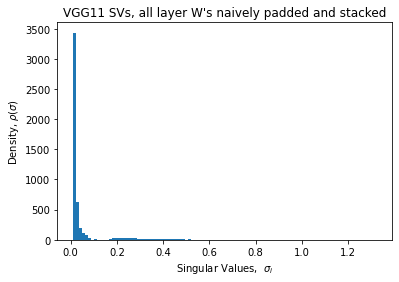

In [17]:
plt.hist(svals, bins=100);
plt.title("VGG11 SVs, all layer W's naively padded and stacked")
plt.xlabel(r"Singular Values,  $\sigma_{i}$")
plt.ylabel(r"Density, $\rho(\sigma)$")

Text(0.5, 0, 'Log EigenValues,  $\\log\\;\\lambda_{i}$')

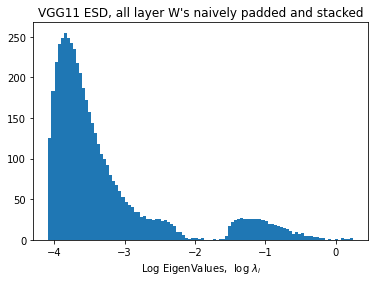

In [18]:
evals = svals*svals
plt.hist(np.log10(evals), bins=100);
plt.title("VGG11 ESD, all layer W's naively padded and stacked")
plt.xlabel(r"Log EigenValues,  $\log\;\lambda_{i}$")

Text(0.5, 0, 'Log EigenValues,  $\\log\\;\\lambda,\\;\\;\\lambda>0.01$')

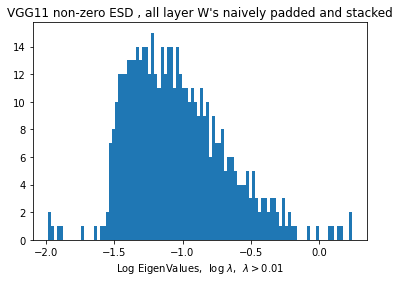

In [37]:
evals_nz = evals[evals>0.01]
plt.hist(np.log10(evals_nz), bins=100);
plt.title("VGG11 non-zero ESD , all layer W's naively padded and stacked")
plt.xlabel(r"Log EigenValues,  $\log\;\lambda,\;\;\lambda>0.01$")

Text(0.5, 1.0, 'VGG11 Stacked ESD, log log plot')

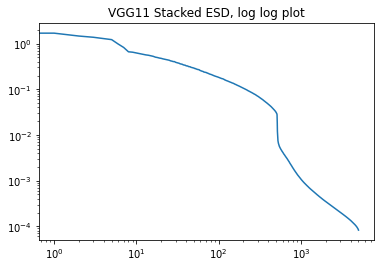

In [19]:
plt.loglog(evals);
plt.title("VGG11 Stacked ESD, log log plot")


Text(0.5, 1.0, 'VGG11 Stacked non-zero ESD, log log plot')

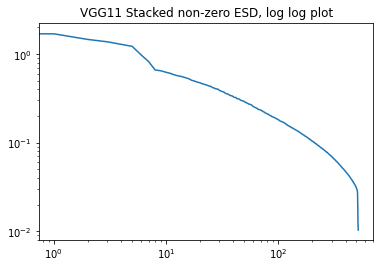

In [38]:
plt.loglog(evals_nz);
plt.title("VGG11 Stacked non-zero ESD, log log plot")

In [39]:
import powerlaw

In [42]:
results = powerlaw.Fit(evals_nz)
results.alpha

Calculating best minimal value for power law fit


2.5611645424322322

In [46]:
layer.evals = evals_nz

#### The savefig option is not working correctly...

In [63]:
params = {'glorot_fix': False, 'normalize':False, 'conv2d_norm':False, 'randomize': False, 
                  'savedir':None, 'savefig':False, 'rescale':True, 'plot':True,
                  'deltaEs':False, 'intra':False, 'channels':None, 'conv2d_fft':False, 
                  'ww2x':False, 'vectors':False, 'smooth':None}

Assuming nested distributions


TypeError: stat: path should be string, bytes, os.PathLike or integer, not NoneType

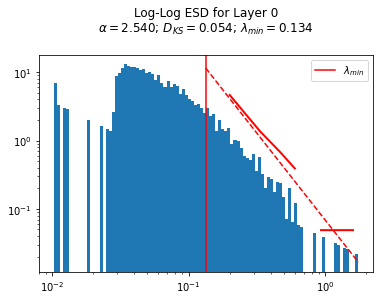

In [66]:
watcher.apply_fit_powerlaw(layer, params=params)